In [1]:
#Libraries we will need.
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython.display as ipd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%load_ext tensorboard

2023-04-19 23:35:09.767365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 23:35:11.575208: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2023-04-19 23:35:11.575470: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2023-04-19 23:35:11.575478: W tensorflow/com

In [2]:
sample = r"../Datasets/environmental-sound-classification-50/audio/audio/1-100032-A-0.wav" # single bark
x,freq = librosa.load(sample)
sr=freq

In [3]:
print(x.shape)
print(type(x))
print(freq)
print(type(freq))

(110250,)
<class 'numpy.ndarray'>
22050
<class 'int'>


Sound can be played with ipd library as follows.

In [4]:
import IPython.display as ipd
ipd.Audio(sample)

<Figure size 1000x300 with 0 Axes>

Text(0.5, 1.0, 'Single Bark Wave Plot')

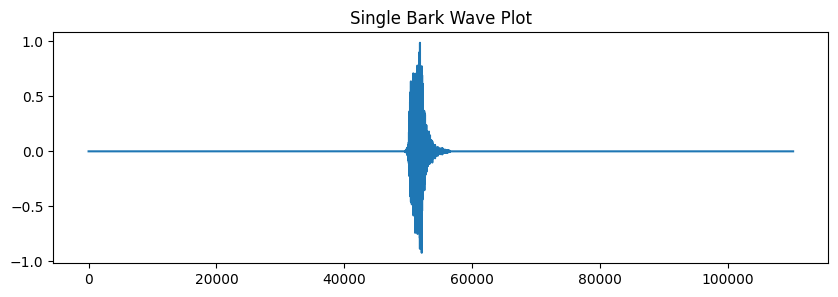

In [8]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10,3))
plt.title("Single Bark Wave Plot")
plt.plot(x)

For 2nd sample .wav we will use multiple bark of a dog.

<Figure size 2000x800 with 0 Axes>

Text(0.5, 1.0, 'Multi Bark Sound Spectogram')

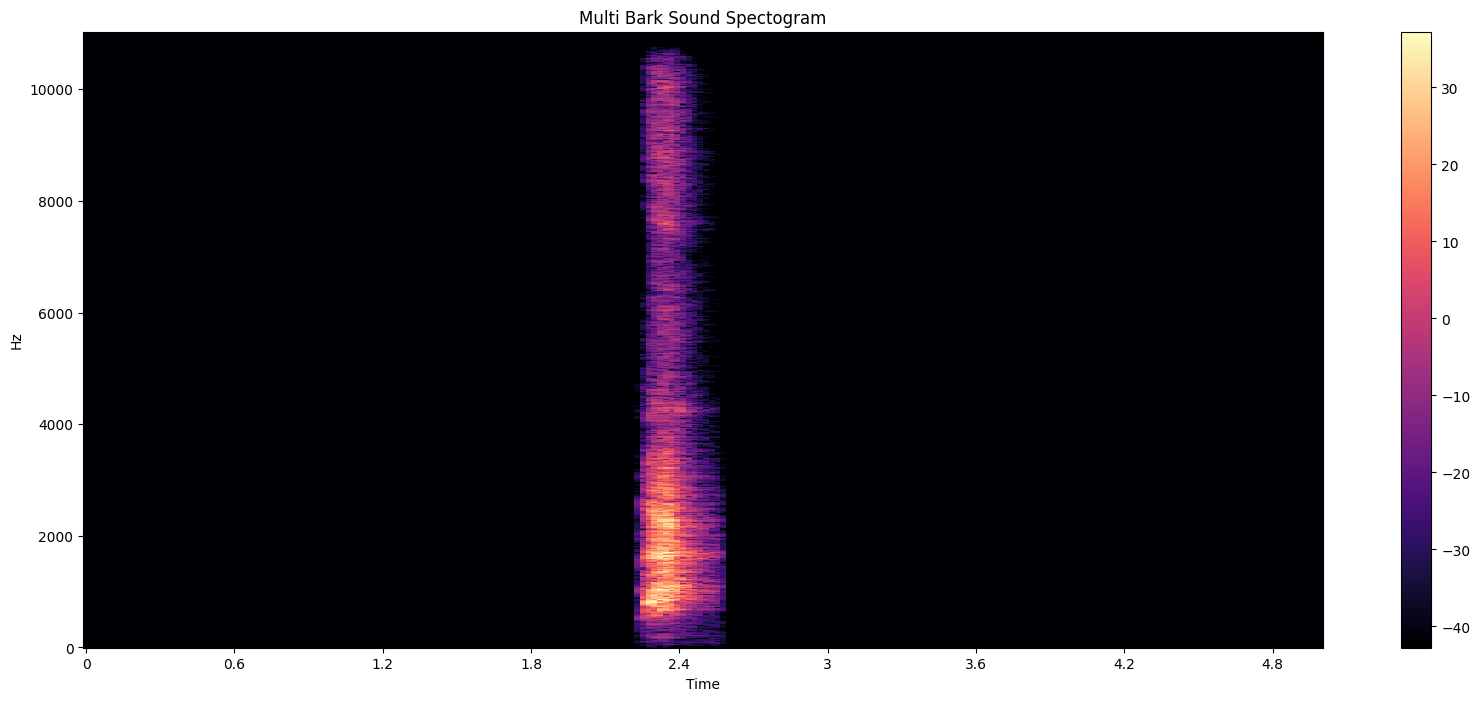

In [10]:
X=librosa.stft(x) #stft -> Short-time Fourier transform
X_db=librosa.amplitude_to_db(abs(X)) #Translation from amplitude to desibel(db) value
plt.figure(figsize=(20,8))
librosa.display.specshow(X_db, sr=sr,x_axis="time",y_axis="hz")
plt.title("Multi Bark Sound Spectogram")
plt.colorbar()

shape of mfcc: (20, 216)


<Figure size 1500x600 with 0 Axes>

Text(0.5, 1.0, 'Mel-Frequency Cepstral Coefficients')

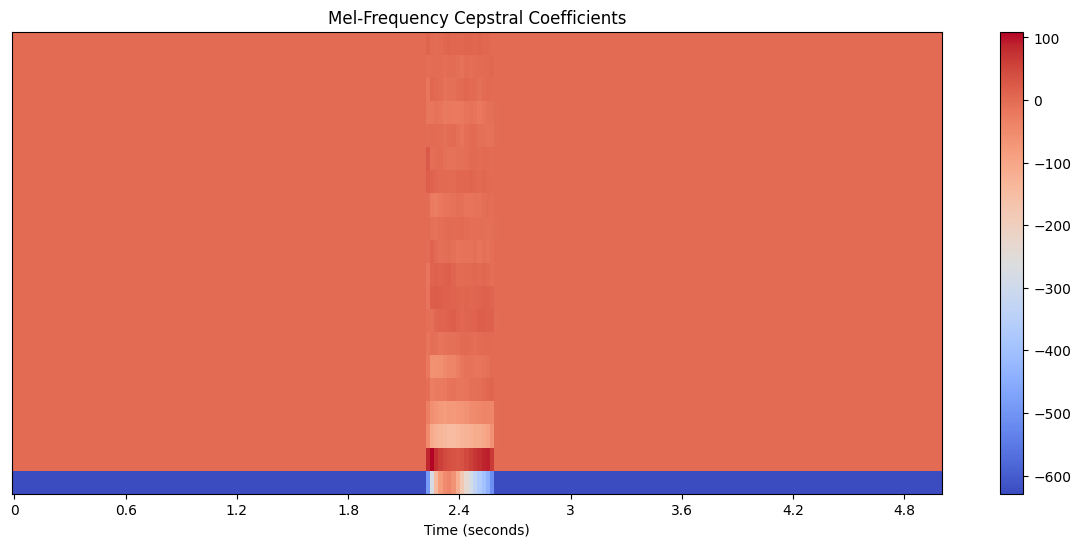

In [12]:
mfcc=librosa.feature.mfcc(y=x,sr=sr)
print("shape of mfcc:" ,mfcc.shape)

plt.figure(figsize=(15,6))
librosa.display.specshow(mfcc,x_axis="s")
plt.title("Mel-Frequency Cepstral Coefficients")
plt.colorbar()

In [23]:
CSV_FILE_PATH = "../Datasets/environmental-sound-classification-50/esc50.csv"  # path of csv file
DATA_PATH = "../Datasets/environmental-sound-classification-50/audio/audio/16000/" # path to folder containing audio files

In [27]:
df = pd.read_csv(CSV_FILE_PATH)
# df.head()
# print("shape of df: ", df.shape)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


shape of df:  (2000, 7)


In [28]:
df=df.drop(['fold','esc10','src_file','take'], axis=1)

In [29]:
classes = df['category'].unique()
# print("Classes are: ",classes)
print("# of Classes are: ",classes.shape[0])

Classes are:  ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw' 'airplane'
 'mouse_click' 'pouring_water' 'train' 'sheep' 'water_drops'
 'church_bells' 'clock_alarm' 'keyboard_typing' 'wind' 'footsteps' 'frog'
 'cow' 'brushing_teeth' 'car_horn' 'crackling_fire' 'helicopter'
 'drinking_sipping' 'rain' 'insects' 'laughing' 'hen' 'engine' 'breathing'
 'crying_baby' 'hand_saw' 'coughing' 'glass_breaking' 'snoring'
 'toilet_flush' 'pig' 'washing_machine' 'clock_tick' 'sneezing' 'rooster'
 'sea_waves' 'siren' 'cat' 'door_wood_creaks' 'crickets']
# of Classes are:  50


In [30]:
class_dict = {i:x for x,i in enumerate(classes)}


In [31]:
#drop duplicates if there are any in filename...
df = df.drop_duplicates(subset=['filename'])

In [32]:
df['target'] = df['category'].map(class_dict)
df.head()
print("df shape: ", df.shape)

,filename,target,category
0,1-100032-A-0.wav,0,dog
1,1-100038-A-14.wav,1,chirping_birds
2,1-100210-A-36.wav,2,vacuum_cleaner
3,1-100210-B-36.wav,2,vacuum_cleaner
4,1-101296-A-19.wav,3,thunderstorm


df shape:  (2000, 3)


In [21]:
X = []
y = []

In [35]:
for data in tqdm(df.iterrows(),  desc='Progress'):
    try:
        sig , sr = librosa.load(DATA_PATH+data[1][0])
        mfcc_ = librosa.feature.mfcc(y=sig , sr=sr, n_mfcc=40)
        X.append(mfcc_)
        y.append(data[1][1])
    except:
        pass

Progress: 1947it [00:49, 48.17it/s]/tmp/ipykernel_7037/881876920.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  sig , sr = librosa.load(DATA_PATH+data[1][0])
/home/namachu/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Progress: 2000it [00:49, 40.57it/s]


In [37]:
X = np.array(X) 
y = np.array(y)

In [38]:
X.shape

(3894, 40, 216)

In [39]:
y = tf.keras.utils.to_categorical(y , num_classes=50)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)


In [40]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (3894, 40, 216, 1)
y Shape is:  (3894, 50)


In [41]:
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [42]:
INPUTSHAPE = (40,216,1)

In [43]:
model =  models.Sequential([
    
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),  
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(512 , activation = 'relu'),
                          layers.Dense(50 , activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 214, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 107, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 105, 128)      36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 53, 128)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 53, 128)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 51, 128)        1

2023-04-19 23:51:35.252415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-19 23:51:35.257999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-19 23:51:35.258064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-19 23:51:35.258477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

_________________________________________________________________


In [44]:
batch_size = 8
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(X_train,y_train ,
            validation_data=(X_test,y_test),
            epochs=40,
            callbacks = [callback],batch_size=batch_size)

Epoch 1/40


2023-04-19 23:51:41.353141: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 107654400 exceeds 10% of free system memory.
2023-04-19 23:51:42.286059: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-19 23:51:43.849454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-19 23:51:45.696916: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-19 23:51:47.341941: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f66b003d9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-19 23:51:47.342005: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Ca

390/390 [==============================] - ETA: 0s - loss: 3.1595 - acc: 0.1457

2023-04-19 23:51:55.944083: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26922240 exceeds 10% of free system memory.
2023-04-19 23:51:56.027524: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26922240 exceeds 10% of free system memory.


390/390 [==============================] - 15s 18ms/step - loss: 3.1595 - acc: 0.1457 - val_loss: 2.5637 - val_acc: 0.2336
Epoch 2/40
390/390 [==============================] - 6s 16ms/step - loss: 2.3617 - acc: 0.3088 - val_loss: 2.1476 - val_acc: 0.3479
Epoch 3/40
390/390 [==============================] - 6s 16ms/step - loss: 1.8950 - acc: 0.4350 - val_loss: 1.8351 - val_acc: 0.4621
Epoch 4/40
390/390 [==============================] - 6s 16ms/step - loss: 1.5627 - acc: 0.5284 - val_loss: 1.6530 - val_acc: 0.4968
Epoch 5/40
390/390 [==============================] - 6s 16ms/step - loss: 1.2511 - acc: 0.6247 - val_loss: 1.3359 - val_acc: 0.5777
Epoch 6/40
390/390 [==============================] - 6s 16ms/step - loss: 1.0815 - acc: 0.6668 - val_loss: 1.0751 - val_acc: 0.6662
Epoch 7/40
390/390 [==============================] - 6s 16ms/step - loss: 0.8830 - acc: 0.7255 - val_loss: 1.0465 - val_acc: 0.6534
Epoch 8/40
390/390 [==============================] - 6s 16ms/step - loss: 0.77

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

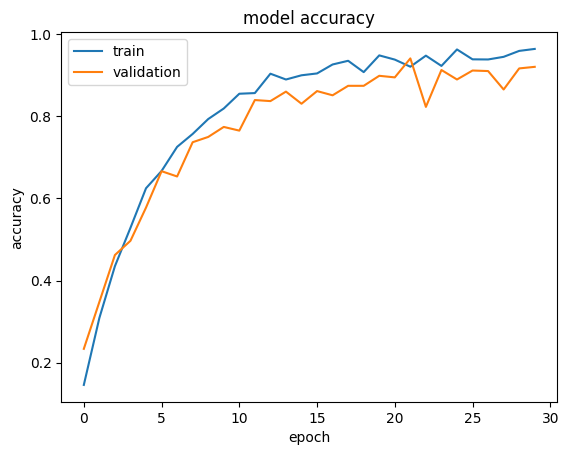

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

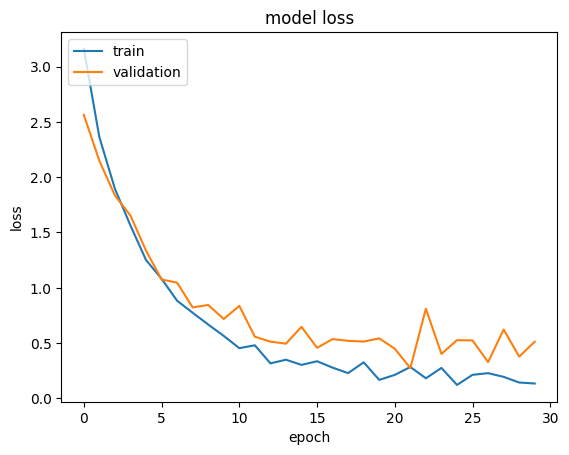

In [45]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()